### 1. Import Data

In [1]:
# Import necessary packages
import pandas as pd
from sodapy import Socrata

# Access and load data from API
# API documentation: https://dev.socrata.com/foundry/data.usaid.gov/a3rc-nmf6
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.usaid.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.usaid.gov,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("a3rc-nmf6", limit=20000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

### 2. Inspect Data

In [2]:
results_df.describe()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
count,10324,10324,10324,10324,10324,10324,10324,10324,10324,9964,...,10324,10324,10324,10324,10324,10324,10324,10324,8588,10037
unique,10324,142,1237,6233,7030,43,4,2,8,4,...,5065,8741,1175,183,88,2,4688,6733,54,6722
top,1,116-ZA-T30,Pre-PQ Process,SCMS-199289,ASN-19166,South Africa,PMO - US,From RDC,N/A - From RDC,Air,...,10000,200000.0,32.0,0.04,"Aurobindo Unit III, India",True,Weight Captured Separately,Freight Included in Commodity Cost,300mg,0.0
freq,1,768,2681,67,54,1406,10265,5404,5404,6113,...,93,29,368,713,3172,7030,1507,1442,990,54


In [3]:
results_df.head()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,19,551.0,29.0,0.97,Ranbaxy Fine Chemicals LTD,True,13,780.34,NaN,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,1000,6200.0,6.2,0.03,"Aurobindo Unit III, India",True,358,4521.5,10mg/ml,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,500,40000.0,80.0,0.8,ABBVIE GmbH & Co.KG Wiesbaden,True,171,1653.78,NaN,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855,16007.06,150mg,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,38000,121600.0,3.2,0.05,"Aurobindo Unit III, India",True,7590,45450.08,30mg,NaN


## Part Two: Extract Data for Use in Model

### 1. Choose Countries and Manufacturing Sites to Focus On
- The original data set contained shipments to 43 unique countries. This research will focus on the the countries that recieved the most shipments. 
- After the top countries have been determined, shipments to all other countries will be removed from the dataset.
- Similarly, the top manufacturing sites that sent shipments to these countries will be determined, and shipments from all other sites will be removed.

In [4]:
# Strip any extra whitespace from the values in country column
results_df['country'].str.strip()

# Return value counts (%) for country column
results_df['country'].value_counts(normalize=True).nlargest(20)

South Africa     0.136188
Nigeria          0.115653
Côte d'Ivoire    0.104901
Uganda           0.075455
Vietnam          0.066641
Zambia           0.066157
Haiti            0.063444
Mozambique       0.061120
Zimbabwe         0.052112
Tanzania         0.050271
Rwanda           0.041651
Congo, DRC       0.032255
Guyana           0.022956
Ethiopia         0.020922
South Sudan      0.015885
Kenya            0.010752
Burundi          0.009492
Namibia          0.009202
Cameroon         0.007265
Botswana         0.006780
Name: country, dtype: float64

In [5]:
# Remove rows not included in the top countries and inspect new data set
countries_to_include = ['South Africa', 'Nigeria', 'Côte d\'Ivoire', 'Uganda', 'Vietnam', 
                     'Zambia', 'Haiti', 'Mozambique', 'Zimbabwe', 'Tanzania']

df_top_countries = results_df[results_df['country'].isin(countries_to_include)]
df_top_countries.describe()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
count,8176,8176,8176,8176,8176,8176,8176,8176,8176,7844,...,8176,8176,8176,8176,8176,8176,8176,8176,7298,7925
unique,8176,53,800,4847,5494,10,3,2,8,4,...,4379,7166,1091,159,77,2,4071,5140,53,5780
top,1,116-ZA-T30,Pre-PQ Process,SCMS-199289,ASN-19166,South Africa,PMO - US,From RDC,N/A - From RDC,Air,...,10000,200000.0,80.0,0.04,"Aurobindo Unit III, India",True,Weight Captured Separately,Freight Included in Commodity Cost,300mg,0.07
freq,1,768,2238,67,54,1406,8118,4415,4415,4176,...,84,29,201,563,2694,5494,1366,1394,830,27


In [6]:
# Strip any extra whitespace from the values in manufacturing_site column
df_top_countries['manufacturing_site'].str.strip()

# Return value counts (%) for manufacturing_site column
df_top_countries['manufacturing_site'].value_counts(normalize=True).nlargest(20)

Aurobindo Unit III, India                                                   0.329501
Mylan (formerly Matrix) Nashik                                              0.143713
Hetero Unit III Hyderabad IN                                                0.086473
Cipla, Goa, India                                                           0.073141
Strides, Bangalore, India.                                                  0.053327
ABBVIE Ludwigshafen Germany                                                 0.040484
Alere Medical Co., Ltd.                                                     0.034124
Inverness Japan                                                             0.022994
ABBVIE (Abbott) Logis. UK                                                   0.022750
BMS Meymac, France                                                          0.017613
Aspen-OSD, Port Elizabeth, SA                                               0.016512
Trinity Biotech, Plc                                             

In [7]:
# Remove rows not included in the top manufacturing sites and inspect new data set
man_site_to_include = ['Aurobindo Unit III, India', 'Mylan (formerly Matrix) Nashik', 'Hetero Unit III Hyderabad IN',
                       'Cipla, Goa, India', 'Strides, Bangalore, India.', 'ABBVIE Ludwigshafen Germany']

df_top_countries_top_man = df_top_countries[df_top_countries['manufacturing_site'].isin(man_site_to_include)]
df_top_countries_top_man.describe()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
count,5941,5941,5941,5941,5941,5941,5941,5941,5941,5755,...,5941,5941,5941,5941,5941,5941,5941,5941,5941,5818
unique,5941,43,513,3544,3892,10,2,2,5,4,...,3679,5419,692,93,6,2,3469,3749,39,4562
top,3,151-NG-T30,Pre-PQ Process,SCMS-199289,ASN-19166,South Africa,PMO - US,From RDC,N/A - From RDC,Air,...,50000,16000.0,11.22,0.04,"Aurobindo Unit III, India",True,Weight Captured Separately,Freight Included in Commodity Cost,300mg,0.07
freq,1,589,1369,67,33,950,5907,3889,3889,2662,...,57,11,127,519,2694,3784,782,847,711,16


### 2. Remove rows that do not include freight cost

In [8]:
# Strip any extra whitespace from the values in freight_cost_usd column
df_top_countries_top_man['freight_cost_usd'].str.strip()

# Remove rows that do not include freight costs and inspect new data set
freight_price_not_listed = ['Freight Included in Commodity Cost', 'Invoiced Separately']
final_df = df_top_countries_top_man[~df_top_countries_top_man['freight_cost_usd'].isin(freight_price_not_listed)]
final_df2 = final_df[~df_top_countries_top_man['freight_cost_usd'].str.contains('See')]
final_df2.describe()

/var/folders/08/r16vjmps66jch4n1446z7m0r0000gn/T/ipykernel_80418/2033593462.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df2 = final_df[~df_top_countries_top_man['freight_cost_usd'].str.contains('See')]


,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
count,3412,3412,3412,3412,3412,3412,3412,3412,3412,3285,...,3412,3412,3412,3412,3412,3412,3412,3412,3412,3340
unique,3412,42,483,3146,3412,10,1,2,5,4,...,2473,3186,442,67,6,1,2488,2827,38,3005
top,3,104-CI-T30,Pre-PQ Process,SCMS-68980,ASN-85,Nigeria,PMO - US,From RDC,N/A - From RDC,Air,...,50000,600500.0,11.22,0.04,"Aurobindo Unit III, India",True,36,9736.1,200mg,960.8
freq,1,363,804,10,1,496,3412,2365,2365,1680,...,40,8,81,329,1402,3412,11,36,374,7


### 3. Remove columns that are not neccesary

In [9]:
columns_to_drop = ['id', 'project_code', 'pq', 'po_so', 'asn_dn', 'managed_by', 'vendor_inco_term', 'pack_price', 
                   'first_line_designation', 'dosage', 'molecule_test_type',
                   'line_item_insurance_usd', 'fulfill_via', 'pq_first_sent_to_client_date',
                   'po_sent_to_vendor_date', 'scheduled_delivery_date', 'delivered_to_client_date',
                   'delivery_recorded_date', 'vendor', 'item_description', 'dosage_form',
                   'product_group', 'unit_of_measure_per_pack']

selected_df = final_df2.drop(columns_to_drop, axis=1)


In [10]:
selected_df.describe()

,country,shipment_mode,sub_classification,brand,line_item_quantity,line_item_value,unit_price,manufacturing_site,weight_kilograms,freight_cost_usd
count,3412,3285,3412,3412,3412,3412,3412,3412,3412,3412
unique,10,4,2,3,2473,3186,67,6,2488,2827
top,Nigeria,Air,Adult,Generic,50000,600500.0,0.04,"Aurobindo Unit III, India",36,9736.1
freq,496,1680,2753,3207,40,8,329,1402,11,36


In [11]:
selected_df.dtypes

country               object
shipment_mode         object
sub_classification    object
brand                 object
line_item_quantity    object
line_item_value       object
unit_price            object
manufacturing_site    object
weight_kilograms      object
freight_cost_usd      object
dtype: object

## Part Three: Clean Data For Use In Model

### Step 1: Identify Any Null Values

In [12]:
selected_df.isnull().sum()

country                 0
shipment_mode         127
sub_classification      0
brand                   0
line_item_quantity      0
line_item_value         0
unit_price              0
manufacturing_site      0
weight_kilograms        0
freight_cost_usd        0
dtype: int64

In [13]:
selected_df['shipment_mode'].unique()

array(['Air', 'Truck', nan, 'Air Charter', 'Ocean'], dtype=object)

In [14]:
selected_df['shipment_mode'].value_counts()

Air            1680
Truck           991
Air Charter     387
Ocean           227
Name: shipment_mode, dtype: int64

### Step 2.1: Replace missing shipment_mode values with 'unknown'
- https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893

In [15]:
selected_df['shipment_mode'] = selected_df['shipment_mode'].fillna('unknown')

In [16]:
selected_df['shipment_mode'].unique()

array(['Air', 'Truck', 'unknown', 'Air Charter', 'Ocean'], dtype=object)

In [17]:
selected_df.isnull().sum()

country               0
shipment_mode         0
sub_classification    0
brand                 0
line_item_quantity    0
line_item_value       0
unit_price            0
manufacturing_site    0
weight_kilograms      0
freight_cost_usd      0
dtype: int64

### Step 2.2 Remove rows that have missing weight_kilograms values

In [18]:
# Count missing values
len(selected_df[selected_df.weight_kilograms == 'Weight Captured Separately'])

5

In [19]:
missing_weight = selected_df[(selected_df['weight_kilograms'] == 'Weight Captured Separately')].index
selected_df.drop(missing_weight, inplace=True)

In [20]:
len(selected_df[selected_df.weight_kilograms == 'Weight Captured Separately'])

0

### Step 3: Change all numeric columns to floats/ints

In [21]:
selected_df[['line_item_quantity', 'line_item_value', 'freight_cost_usd', 'weight_kilograms', 'unit_price']] = selected_df[['line_item_quantity', 'line_item_value', 'freight_cost_usd', 'weight_kilograms', 'unit_price']].apply(pd.to_numeric)
selected_df.dtypes

country                object
shipment_mode          object
sub_classification     object
brand                  object
line_item_quantity      int64
line_item_value       float64
unit_price            float64
manufacturing_site     object
weight_kilograms        int64
freight_cost_usd      float64
dtype: object

### Step 4: Inspect All Numeric Columns for Outliers & Remove Outliers

### Step 4.1 Remove Outliers From weight_kilograms

<AxesSubplot:ylabel='Frequency'>

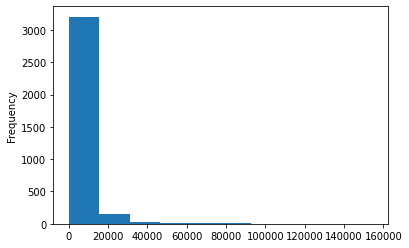

In [23]:
# View histogram
selected_df['weight_kilograms'].plot.hist()

<AxesSubplot:>

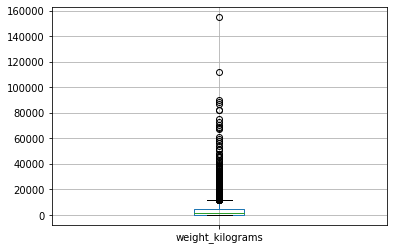

In [24]:
# View boxplot
selected_df.boxplot(column='weight_kilograms')

In [25]:
# Describe data
selected_df['weight_kilograms'].describe()

count      3407.000000
mean       4406.517464
std        8410.233265
min           1.000000
25%         394.500000
50%        1736.000000
75%        4961.500000
max      154780.000000
Name: weight_kilograms, dtype: float64

In [26]:
# Identify upper and lower limits
Q1 = selected_df['weight_kilograms'].quantile(0.25)
Q3 = selected_df['weight_kilograms'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.7 * IQR
Upper = Q3 + 1.7 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -7369.4, upper limit: 12725.4


In [27]:
# Remove outliers
outliers_low = (selected_df['weight_kilograms'] < Lower)
outliers_upper = (selected_df['weight_kilograms'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

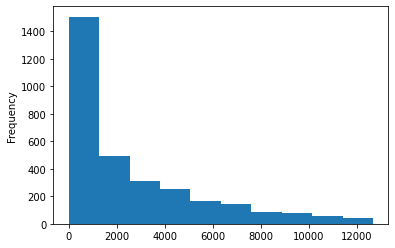

In [28]:
# View histogram with outliers removed
selected_df['weight_kilograms'].plot.hist()

<AxesSubplot:>

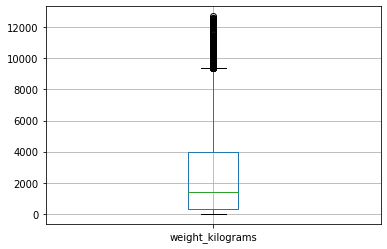

In [29]:
# View boxplot with outliers removed
selected_df.boxplot(column='weight_kilograms')

In [30]:
# Describe data with outliers removed
selected_df['weight_kilograms'].describe()

count     3142.000000
mean      2605.292807
std       2941.189363
min          1.000000
25%        346.000000
50%       1409.000000
75%       3956.500000
max      12686.000000
Name: weight_kilograms, dtype: float64

### Step 4.2 Remove Outliers From line_item_quantity

<AxesSubplot:ylabel='Frequency'>

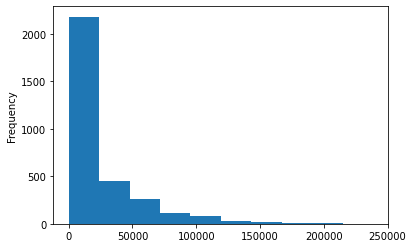

In [31]:
# View histogram
selected_df['line_item_quantity'].plot.hist()

<AxesSubplot:>

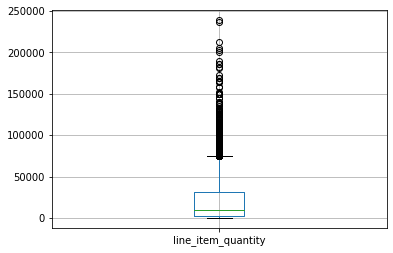

In [32]:
# View boxplot
selected_df.boxplot(column='line_item_quantity')

In [33]:
# Describe data
selected_df['line_item_quantity'].describe()

count      3142.000000
mean      22721.262572
std       31137.527496
min           1.000000
25%        2178.500000
50%        9800.000000
75%       31218.250000
max      238627.000000
Name: line_item_quantity, dtype: float64

In [34]:
# Identify upper and lower limits
Q1 = selected_df['line_item_quantity'].quantile(0.25)
Q3 = selected_df['line_item_quantity'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.7 * IQR
Upper = Q3 + 1.7 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -47189.075, upper limit: 80585.825


In [35]:
# Remove outliers
outliers_low = (selected_df['line_item_quantity'] < Lower)
outliers_upper = (selected_df['line_item_quantity'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

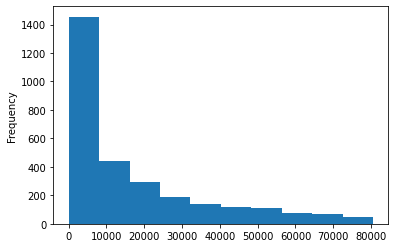

In [36]:
# View histogram with outliers removed
selected_df['line_item_quantity'].plot.hist()

<AxesSubplot:>

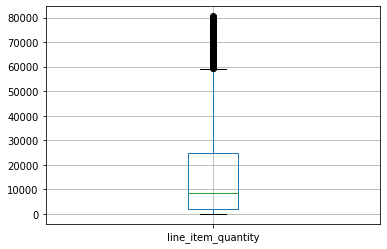

In [37]:
# View boxplot with outliers removed
selected_df.boxplot(column='line_item_quantity')

In [38]:
# Describe data with outliers removed
selected_df['line_item_quantity'].describe()

count     2952.000000
mean     16783.759146
std      19730.614035
min          1.000000
25%       2014.750000
50%       8400.000000
75%      24968.750000
max      80516.000000
Name: line_item_quantity, dtype: float64

### Step 4.3 Remove Outliers From line_item_value

<AxesSubplot:ylabel='Frequency'>

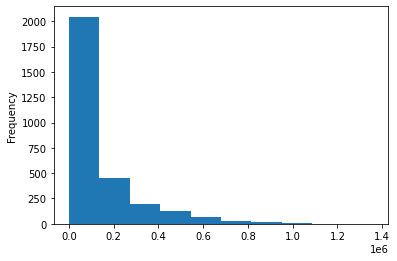

In [39]:
# View histogram
selected_df['line_item_value'].plot.hist()

<AxesSubplot:>

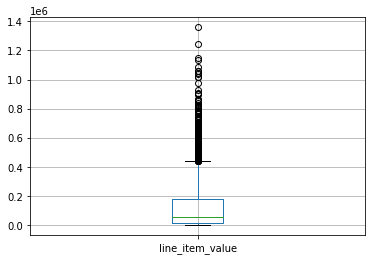

In [40]:
# View boxplot
selected_df.boxplot(column='line_item_value')

In [41]:
# Describe data
selected_df['line_item_value'].describe()

count    2.952000e+03
mean     1.293958e+05
std      1.778426e+05
min      0.000000e+00
25%      1.074603e+04
50%      5.351277e+04
75%      1.818465e+05
max      1.359241e+06
Name: line_item_value, dtype: float64

In [42]:
# Identify upper and lower limits
Q1 = selected_df['line_item_value'].quantile(0.25)
Q3 = selected_df['line_item_value'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.7 * IQR
Upper = Q3 + 1.7 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -280124.769, upper limit: 472717.299


In [43]:
# Remove outliers
outliers_low = (selected_df['line_item_value'] < Lower)
outliers_upper = (selected_df['line_item_value'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

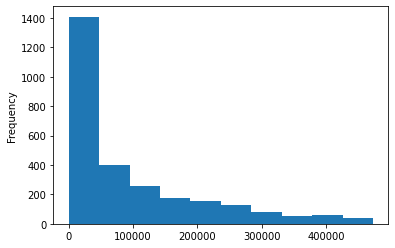

In [44]:
# View histogram with outliers removed
selected_df['line_item_value'].plot.hist()

<AxesSubplot:>

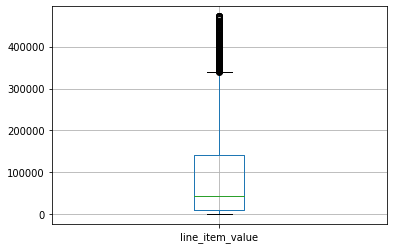

In [45]:
# View boxplot with outliers removed
selected_df.boxplot(column='line_item_value')

In [46]:
# Describe data with outliers removed
selected_df['line_item_value'].describe()

count      2759.000000
mean      93663.267292
std      111533.358555
min           0.000000
25%        9792.500000
50%       44067.840000
75%      142111.200000
max      472500.000000
Name: line_item_value, dtype: float64

### Step 4.4 Remove Outliers From line_item_quantity

<AxesSubplot:ylabel='Frequency'>

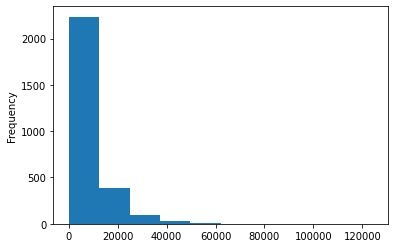

In [47]:
# View histogram
selected_df['freight_cost_usd'].plot.hist()

<AxesSubplot:>

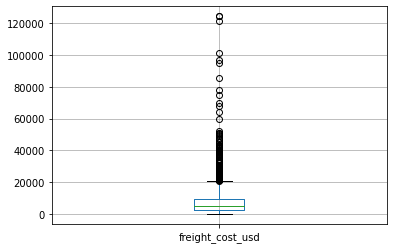

In [48]:
# View boxplot
selected_df.boxplot(column='freight_cost_usd')

In [49]:
# Describe data
selected_df['freight_cost_usd'].describe()

count      2759.000000
mean       7967.007408
std        9764.742616
min          17.720000
25%        2336.365000
50%        4916.000000
75%        9759.025000
max      124350.840000
Name: freight_cost_usd, dtype: float64

In [50]:
# Identify upper and lower limits
Q1 = selected_df['freight_cost_usd'].quantile(0.25)
Q3 = selected_df['freight_cost_usd'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.7 * IQR
Upper = Q3 + 1.7 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -10282.157, upper limit: 22377.547


In [51]:
# Remove outliers
outliers_low = (selected_df['freight_cost_usd'] < Lower)
outliers_upper = (selected_df['freight_cost_usd'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

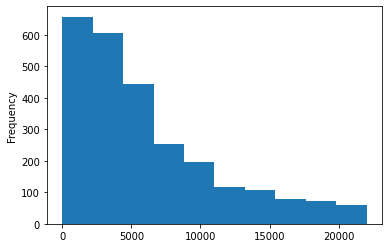

In [52]:
# View histogram with outliers removed
selected_df['freight_cost_usd'].plot.hist()

<AxesSubplot:>

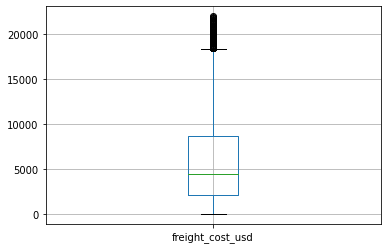

In [53]:
# View boxplot with outliers removed
selected_df.boxplot(column='freight_cost_usd')

In [106]:
# Describe data with outliers removed
selected_df['freight_cost_usd'].describe()

count     2592.000000
mean      6169.457072
std       5148.335573
min         17.720000
25%       2183.020000
50%       4520.315000
75%       8691.865000
max      22007.390000
Name: freight_cost_usd, dtype: float64

### Step 4: One-hot encoding
- https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/

In [55]:
y = pd.get_dummies(selected_df.country, prefix='country')
print(y.head())

    country_Côte d'Ivoire  country_Haiti  country_Mozambique  country_Nigeria  \
1                       0              0                   0                0   
5                       0              0                   0                1   
7                       0              0                   0                0   
18                      0              0                   0                0   
23                      0              0                   0                0   

    country_South Africa  country_Tanzania  country_Uganda  country_Vietnam  \
1                      0                 0               0                1   
5                      0                 0               0                0   
7                      0                 1               0                0   
18                     0                 0               0                1   
23                     0                 0               0                1   

    country_Zambia  country_Zimbabwe  

In [56]:
# Drop the categorical 'country' column
selected_df = selected_df.drop('country',axis = 1)

In [57]:
# Join the one-hot values with the df
selected_df = selected_df.join(y)

In [58]:
selected_df.head()

,shipment_mode,sub_classification,brand,line_item_quantity,line_item_value,unit_price,manufacturing_site,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,country_Mozambique,country_Nigeria,country_South Africa,country_Tanzania,country_Uganda,country_Vietnam,country_Zambia,country_Zimbabwe
1,Air,Pediatric,Generic,1000,6200.00,0.03,"Aurobindo Unit III, India",358,4521.50,0,0,0,0,0,0,0,1,0,0
5,Air,Pediatric,Generic,416,2225.60,0.02,"Aurobindo Unit III, India",504,5920.42,0,0,0,1,0,0,0,0,0,0
7,Air,Adult,Generic,16667,60834.55,0.06,"Aurobindo Unit III, India",1478,6212.41,0,0,0,0,0,1,0,0,0,0
18,Air,Adult,Generic,525,3465.00,0.11,"Cipla, Goa, India",34,807.47,0,0,0,0,0,0,0,1,0,0
23,Air,Pediatric,Generic,1000,1920.00,0.01,"Aurobindo Unit III, India",941,4193.49,0,0,0,0,0,0,0,1,0,0


In [59]:
# Encode 
y = pd.get_dummies(selected_df.shipment_mode, prefix='ship_mode')
# Drop old column
selected_df = selected_df.drop('shipment_mode',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,sub_classification,brand,line_item_quantity,line_item_value,unit_price,manufacturing_site,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,...,country_Tanzania,country_Uganda,country_Vietnam,country_Zambia,country_Zimbabwe,ship_mode_Air,ship_mode_Air Charter,ship_mode_Ocean,ship_mode_Truck,ship_mode_unknown
1,Pediatric,Generic,1000,6200.00,0.03,"Aurobindo Unit III, India",358,4521.50,0,0,...,0,0,1,0,0,1,0,0,0,0
5,Pediatric,Generic,416,2225.60,0.02,"Aurobindo Unit III, India",504,5920.42,0,0,...,0,0,0,0,0,1,0,0,0,0
7,Adult,Generic,16667,60834.55,0.06,"Aurobindo Unit III, India",1478,6212.41,0,0,...,1,0,0,0,0,1,0,0,0,0
18,Adult,Generic,525,3465.00,0.11,"Cipla, Goa, India",34,807.47,0,0,...,0,0,1,0,0,1,0,0,0,0
23,Pediatric,Generic,1000,1920.00,0.01,"Aurobindo Unit III, India",941,4193.49,0,0,...,0,0,1,0,0,1,0,0,0,0


In [60]:
# Encode 
y = pd.get_dummies(selected_df.sub_classification, prefix='class')
# Drop old column
selected_df = selected_df.drop('sub_classification', axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,brand,line_item_quantity,line_item_value,unit_price,manufacturing_site,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,country_Mozambique,...,country_Vietnam,country_Zambia,country_Zimbabwe,ship_mode_Air,ship_mode_Air Charter,ship_mode_Ocean,ship_mode_Truck,ship_mode_unknown,class_Adult,class_Pediatric
1,Generic,1000,6200.00,0.03,"Aurobindo Unit III, India",358,4521.50,0,0,0,...,1,0,0,1,0,0,0,0,0,1
5,Generic,416,2225.60,0.02,"Aurobindo Unit III, India",504,5920.42,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,Generic,16667,60834.55,0.06,"Aurobindo Unit III, India",1478,6212.41,0,0,0,...,0,0,0,1,0,0,0,0,1,0
18,Generic,525,3465.00,0.11,"Cipla, Goa, India",34,807.47,0,0,0,...,1,0,0,1,0,0,0,0,1,0
23,Generic,1000,1920.00,0.01,"Aurobindo Unit III, India",941,4193.49,0,0,0,...,1,0,0,1,0,0,0,0,0,1


In [61]:
# Inspect unique values in brand
selected_df['brand'].unique()

array(['Generic', 'Aluvia', 'Norvir'], dtype=object)

In [62]:
# Encode brand
y = pd.get_dummies(selected_df.brand, prefix='brand')
# Drop old column
selected_df = selected_df.drop('brand',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,line_item_quantity,line_item_value,unit_price,manufacturing_site,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,country_Mozambique,country_Nigeria,...,ship_mode_Air,ship_mode_Air Charter,ship_mode_Ocean,ship_mode_Truck,ship_mode_unknown,class_Adult,class_Pediatric,brand_Aluvia,brand_Generic,brand_Norvir
1,1000,6200.00,0.03,"Aurobindo Unit III, India",358,4521.50,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
5,416,2225.60,0.02,"Aurobindo Unit III, India",504,5920.42,0,0,0,1,...,1,0,0,0,0,0,1,0,1,0
7,16667,60834.55,0.06,"Aurobindo Unit III, India",1478,6212.41,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
18,525,3465.00,0.11,"Cipla, Goa, India",34,807.47,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
23,1000,1920.00,0.01,"Aurobindo Unit III, India",941,4193.49,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0


In [63]:
# Encode brand
y = pd.get_dummies(selected_df.manufacturing_site, prefix='manufacturing_site')
# Drop old column
selected_df = selected_df.drop('manufacturing_site',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,country_Mozambique,country_Nigeria,country_South Africa,...,class_Pediatric,brand_Aluvia,brand_Generic,brand_Norvir,manufacturing_site_ABBVIE Ludwigshafen Germany,"manufacturing_site_Aurobindo Unit III, India","manufacturing_site_Cipla, Goa, India",manufacturing_site_Hetero Unit III Hyderabad IN,manufacturing_site_Mylan (formerly Matrix) Nashik,"manufacturing_site_Strides, Bangalore, India."
1,1000,6200.00,0.03,358,4521.50,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
5,416,2225.60,0.02,504,5920.42,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
7,16667,60834.55,0.06,1478,6212.41,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
18,525,3465.00,0.11,34,807.47,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
23,1000,1920.00,0.01,941,4193.49,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


### Step 6: Normalize Data

In [64]:
df_max_scaled = selected_df.copy()

In [65]:
for column in df_max_scaled.columns:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
display(df_max_scaled)

,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,country_Mozambique,country_Nigeria,country_South Africa,...,class_Pediatric,brand_Aluvia,brand_Generic,brand_Norvir,manufacturing_site_ABBVIE Ludwigshafen Germany,"manufacturing_site_Aurobindo Unit III, India","manufacturing_site_Cipla, Goa, India",manufacturing_site_Hetero Unit III Hyderabad IN,manufacturing_site_Mylan (formerly Matrix) Nashik,"manufacturing_site_Strides, Bangalore, India."
1,0.012500,0.013122,0.036145,0.028399,0.205454,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.005200,0.004710,0.024096,0.039981,0.269020,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.208338,0.128750,0.072289,0.117246,0.282287,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18,0.006562,0.007333,0.132530,0.002697,0.036691,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23,0.012500,0.004063,0.012048,0.074647,0.190549,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10296,0.164125,0.517975,0.192771,0.256386,0.204263,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10302,0.596662,0.193963,0.036145,0.505156,0.117804,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10304,0.356450,0.465912,0.156627,0.299223,0.162086,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10310,0.225000,0.137143,0.072289,0.178724,0.172020,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Part Five: Data Exploration

In [66]:
df_max_scaled.describe()

,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,country_Mozambique,country_Nigeria,country_South Africa,...,class_Pediatric,brand_Aluvia,brand_Generic,brand_Norvir,manufacturing_site_ABBVIE Ludwigshafen Germany,"manufacturing_site_Aurobindo Unit III, India","manufacturing_site_Cipla, Goa, India",manufacturing_site_Hetero Unit III Hyderabad IN,manufacturing_site_Mylan (formerly Matrix) Nashik,"manufacturing_site_Strides, Bangalore, India."
count,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,...,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000
mean,0.167680,0.189624,0.207766,0.136595,0.280336,0.162423,0.077932,0.069059,0.116127,0.061728,...,0.225694,0.050154,0.932870,0.016975,0.083333,0.443287,0.091821,0.102238,0.201003,0.078318
std,0.205385,0.229200,0.200023,0.161764,0.233937,0.368909,0.268116,0.253603,0.320438,0.240708,...,0.418119,0.218305,0.250295,0.129204,0.276439,0.496869,0.288829,0.303019,0.400828,0.268723
min,0.000013,0.000000,0.000000,0.000079,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.022209,0.019683,0.060241,0.019673,0.099195,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.079537,0.087110,0.156627,0.073814,0.205400,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.245156,0.281179,0.253012,0.199925,0.394952,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
df_max_scaled.corr()

,line_item_quantity,line_item_value,unit_price,weight_kilograms,freight_cost_usd,country_Côte d'Ivoire,country_Haiti,country_Mozambique,country_Nigeria,country_South Africa,...,class_Pediatric,brand_Aluvia,brand_Generic,brand_Norvir,manufacturing_site_ABBVIE Ludwigshafen Germany,"manufacturing_site_Aurobindo Unit III, India","manufacturing_site_Cipla, Goa, India",manufacturing_site_Hetero Unit III Hyderabad IN,manufacturing_site_Mylan (formerly Matrix) Nashik,"manufacturing_site_Strides, Bangalore, India."
line_item_quantity,1.000000,0.717399,-0.146305,0.643593,0.412094,-0.140350,-0.143591,-0.006467,-0.001919,0.275933,...,-0.186068,-0.132440,0.167458,-0.100627,-0.191274,-0.084874,0.087985,0.156400,-0.042964,0.146856
line_item_value,0.717399,1.000000,0.237353,0.508357,0.373535,-0.098912,-0.151013,-0.006265,0.038599,0.155813,...,-0.307826,0.127710,-0.059757,-0.100019,0.013262,-0.113371,0.040895,0.054438,0.054112,0.009926
unit_price,-0.146305,0.237353,1.000000,-0.140924,-0.069929,0.035165,-0.086395,-0.084224,0.018164,-0.079498,...,-0.348117,0.317789,-0.344999,0.131391,0.294687,-0.204372,-0.112862,-0.097113,0.306730,-0.151970
weight_kilograms,0.643593,0.508357,-0.140924,1.000000,0.452823,-0.088534,-0.122988,0.113828,-0.026838,0.169537,...,-0.060589,-0.073871,0.115879,-0.099668,-0.145540,0.010444,0.077000,0.090845,-0.066323,0.044134
freight_cost_usd,0.412094,0.373535,-0.069929,0.452823,1.000000,-0.037842,-0.028732,-0.085258,0.264877,-0.021857,...,-0.125396,-0.064980,0.112257,-0.107673,-0.136943,0.011608,0.025991,0.042171,-0.002907,0.048259
country_Côte d'Ivoire,-0.140350,-0.098912,0.035165,-0.088534,-0.037842,1.000000,-0.128023,-0.119939,-0.159618,-0.112951,...,0.102544,-0.014928,0.005273,0.015007,-0.015454,0.068170,-0.045845,-0.096817,0.021867,0.015682
country_Haiti,-0.143591,-0.151013,-0.086395,-0.122988,-0.028732,-0.128023,1.000000,-0.079182,-0.105377,-0.074568,...,0.194206,-0.000865,0.003222,-0.004780,0.063355,0.044778,-0.022666,-0.003097,-0.059625,-0.031178
country_Mozambique,-0.006467,-0.006265,-0.084224,0.113828,-0.085258,-0.119939,-0.079182,1.000000,-0.098723,-0.069860,...,-0.037851,-0.027729,0.006179,0.034882,-0.021562,-0.010256,-0.012835,0.078848,-0.045484,0.033873
country_Nigeria,-0.001919,0.038599,0.018164,-0.026838,0.264877,-0.159618,-0.105377,-0.098723,1.000000,-0.092971,...,-0.100632,-0.039153,0.053925,-0.038310,-0.057004,0.071681,-0.036022,-0.046798,0.013516,-0.002571
country_South Africa,0.275933,0.155813,-0.079498,0.169537,-0.021857,-0.112951,-0.074568,-0.069860,-0.092971,1.000000,...,0.007243,-0.058939,0.068806,-0.033706,-0.077336,0.190633,0.068330,-0.086557,-0.128649,-0.056868


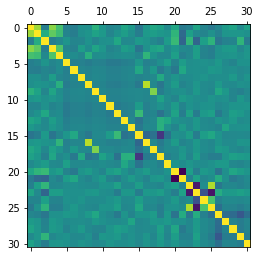

In [68]:
import matplotlib.pyplot as plt

plt.matshow(df_max_scaled.corr())
plt.show()

## Part Six: Create A Model to Predict Weight

### Step 1: Split Data into Train and Test

In [69]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_max_scaled, 
                        test_size=0.2, random_state=123)
print('Train size: ', len(train_set), 'Test size: ', len(test_set))

Train size:  2073 Test size:  519


### Step 2: Select columns for X

In [98]:
columns_x = ['line_item_quantity', 'line_item_value', 'class_Adult', 'unit_price', 'brand_Generic']

### Step 3: Linear Regression

In [99]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['weight_kilograms']

X_test = test_set[columns_x]
y_test = test_set['weight_kilograms']


lr_model = LinearRegression()
lr_model.fit(X, y)

y_pred = lr_model.predict(X)
print('Results for linear regression on training data')
print('  Default settings')
print('Internal parameters:')
print('   Bias is ', lr_model.intercept_)
print('   Coefficients', lr_model.coef_)
print('   Score', lr_model.score(X, y))

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = lr_model.predict(X_test)
print()
print('Results for linear regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for linear regression on training data
  Default settings
Internal parameters:
   Bias is  0.08074525604915475
   Coefficients [ 0.40830805  0.12863169 -0.02391458 -0.07559523 -0.00156116]
   Score 0.4233526940393074
MAE is    0.07382434229572449
RMSE is   0.12516827459952262
MSE is    0.0156670969662215
R^2       0.4233526940393074

Results for linear regression on test data
MAE is    0.06690723968960877
RMSE is   0.10899703615879322
MSE is    0.011880353891401277
R^2       0.46261175497643636


### Step 4: Decision Tree Regression

In [100]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['weight_kilograms']

X_test = test_set[columns_x]
y_test = test_set['weight_kilograms']

dt_model = DecisionTreeRegressor(random_state = 0, max_depth=5) 
dt_model.fit(X, y)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [101]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.06212651996845545
RMSE is   0.10907492761146727
MSE is    0.011897339833446825
R^2       0.5621033700214253

Results for decision tree regression on test data
MAE is    0.06470518039890699
RMSE is   0.1091256889253271
MSE is    0.011908415983427258
R^2       0.4613424124531933


### Step 5: Extra Tree Regression

In [104]:
# import the regressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['weight_kilograms']

X_test = test_set[columns_x]
y_test = test_set['weight_kilograms']

dt_model = ExtraTreesRegressor(random_state = 0, n_estimators=30)
dt_model.fit(X, y)

ExtraTreesRegressor(n_estimators=30, random_state=0)

In [105]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.0010025458465007034
RMSE is   0.009802116768138249
MSE is    9.608149313621703e-05
R^2       0.996463599204809

Results for decision tree regression on test data
MAE is    0.06387249169220137
RMSE is   0.12071996404249533
MSE is    0.014573309718421365
R^2       0.3408003326032589


## Part Seven: Create A Model to Predict Freight Price

### Step 1: Split Data into Train and Test

In [72]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_max_scaled, 
                        test_size=0.2, random_state=123)
print('Train size: ', len(train_set), 'Test size: ', len(test_set))

Train size:  2073 Test size:  519


### Step 2: Select columns for X

In [73]:
columns_x = ['line_item_quantity', 'unit_price', 'line_item_value', 'class_Adult', 'weight_kilograms', 'ship_mode_Air Charter', 
             'country_Nigeria', 'country_Haiti', 'country_Uganda', 'brand_Generic',
             'manufacturing_site_ABBVIE Ludwigshafen Germany', 'manufacturing_site_Aurobindo Unit III, India', 
             'country_Uganda']

### Step 3: Linear Regression

In [74]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['freight_cost_usd']

X_test = test_set[columns_x]
y_test = test_set['freight_cost_usd']


lr_model = LinearRegression()
lr_model.fit(X, y)

y_pred = lr_model.predict(X)
print('Results for linear regression on training data')
print('  Default settings')
print('Internal parameters:')
print('   Bias is ', lr_model.intercept_)
print('   Coefficients', lr_model.coef_)
print('   Score', lr_model.score(X, y))

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = lr_model.predict(X_test)
print()
print('Results for linear regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for linear regression on training data
  Default settings
Internal parameters:
   Bias is  0.13685479940400844
   Coefficients [ 0.097858   -0.05429016  0.14700823  0.02383555  0.45380576  0.17032245
  0.09677975  0.07020373  0.0120424  -0.00240662 -0.04108761  0.00313373
  0.0120424 ]
   Score 0.3401984795171068
MAE is    0.14358517201850815
RMSE is   0.19048988830893118
MSE is    0.03628639754794907
R^2       0.3401984795171068

Results for linear regression on test data
MAE is    0.14548314013368235
RMSE is   0.1905248304425987
MSE is    0.03629971101518099
R^2       0.3220600373664919


### Decision Tree Regression

In [75]:
columns_x = ['line_item_quantity', 'unit_price', 'line_item_value',
             'weight_kilograms', 'ship_mode_Air Charter', 
             'country_Vietnam', 'country_Nigeria', 'country_Haiti', 'country_Uganda',
             'manufacturing_site_ABBVIE Ludwigshafen Germany', 'manufacturing_site_Aurobindo Unit III, India', 
             'country_Uganda', 'brand_Norvir']

In [76]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['freight_cost_usd']

X_test = test_set[columns_x]
y_test = test_set['freight_cost_usd']

dt_model = DecisionTreeRegressor(random_state = 0, max_depth=5) 
dt_model.fit(X, y)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [76]:
#y_test_points = dt_model.predict(X_test)

#plt.figure()
#plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
#plt.plot(X_test, y_test_points, color="cornflowerblue", label="max_depth=2", linewidth=2)
#plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
#plt.title("Decision Tree Regression")
#plt.legend()
#plt.show()

In [77]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.12210121597269052
RMSE is   0.1683445990295083
MSE is    0.028339904022405923
R^2       0.48469087515193277

Results for decision tree regression on test data
MAE is    0.13208924552226886
RMSE is   0.1792827399204294
MSE is    0.032142300833376325
R^2       0.39970458120669217


### Decision Tree Regression with Ada Boost

In [78]:
columns_x = ['line_item_quantity', 'unit_price', 'line_item_value', 'weight_kilograms', 'ship_mode_Air Charter', 
             'country_Vietnam', 'country_Nigeria', 'country_Haiti', 'country_Uganda', 'brand_Generic',
             'manufacturing_site_ABBVIE Ludwigshafen Germany', 'manufacturing_site_Aurobindo Unit III, India', 
             'country_Uganda', 'brand_Norvir', 'class_Adult']

In [78]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor

X = train_set[columns_x]
y = train_set['freight_cost_usd']

X_test = test_set[columns_x]
y_test = test_set['freight_cost_usd']

dt_model = AdaBoostRegressor(DecisionTreeRegressor(random_state = 0, max_depth=5), n_estimators=4, random_state=1) 
dt_model.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=0),
                  n_estimators=4, random_state=1)

In [79]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.1248724207277431
RMSE is   0.1668836007404723
MSE is    0.02785013619610536
R^2       0.4935964038986127

Results for decision tree regression on test data
MAE is    0.13220509410918657
RMSE is   0.17799234198376382
MSE is    0.031681273804865136
R^2       0.40831480530327513


### Random Forest Regressor

In [80]:
columns_x = ['line_item_quantity', 'unit_price', 'line_item_value',
             'weight_kilograms', 'ship_mode_Air Charter', 
             'country_Vietnam', 'country_Nigeria', 'country_Haiti', 'country_Uganda',
             'manufacturing_site_ABBVIE Ludwigshafen Germany', 'manufacturing_site_Aurobindo Unit III, India', 
             'country_Uganda', 'brand_Norvir']

In [81]:
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['freight_cost_usd']

X_test = test_set[columns_x]
y_test = test_set['freight_cost_usd']

dt_model = RandomForestRegressor(random_state = 0, max_depth=5)
dt_model.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=0)

In [82]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.11918698301137479
RMSE is   0.1635414384610818
MSE is    0.0267458020939198
R^2       0.5136766920776834

Results for decision tree regression on test data
MAE is    0.12681370632257333
RMSE is   0.17173100438315844
MSE is    0.029491537866448387
R^2       0.44921070939591823


### Extra Trees Regressor

In [83]:
columns_x = ['line_item_quantity', 'unit_price', 'line_item_value',
             'weight_kilograms', 'ship_mode_Air Charter', 
             'country_Vietnam', 'country_Nigeria', 'country_Haiti', 'country_Uganda',
             'manufacturing_site_ABBVIE Ludwigshafen Germany', 'manufacturing_site_Aurobindo Unit III, India', 
             'country_Uganda', 'brand_Norvir']

In [84]:
# import the regressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['freight_cost_usd']

X_test = test_set[columns_x]
y_test = test_set['freight_cost_usd']

dt_model = ExtraTreesRegressor(random_state = 0, n_estimators=30)
dt_model.fit(X, y)

ExtraTreesRegressor(n_estimators=30, random_state=0)

In [85]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.00012925645440575476
RMSE is   0.0022215150146468994
MSE is    4.935128960301614e-06
R^2       0.9999102637403594

Results for decision tree regression on test data
MAE is    0.12035064714407985
RMSE is   0.1750323080428927
MSE is    0.030636308858822073
R^2       0.42783075947099525


### Gradient Boosting Regressor

In [86]:
columns_x = ['line_item_quantity', 'unit_price', 'line_item_value',
             'weight_kilograms', 'ship_mode_Air Charter', 
             'country_Vietnam', 'country_Nigeria', 'country_Haiti', 'country_Uganda',
             'manufacturing_site_ABBVIE Ludwigshafen Germany', 'manufacturing_site_Aurobindo Unit III, India', 
             'country_Uganda', 'brand_Norvir']

In [87]:
# import the regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['freight_cost_usd']

X_test = test_set[columns_x]
y_test = test_set['freight_cost_usd']

dt_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0,
            loss='squared_error')
dt_model.fit(X, y)

GradientBoostingRegressor(max_depth=4, random_state=0)

In [88]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.0974055748583824
RMSE is   0.13303057340594218
MSE is    0.01769713346071377
R^2       0.6782101185399266

Results for decision tree regression on test data
MAE is    0.12059724900524733
RMSE is   0.17010382255974246
MSE is    0.028935310449436348
R^2       0.45959891315178747
